In [1]:
!pip install d2l==0.16

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

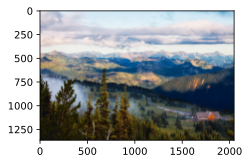

In [3]:
d2l.set_figsize()
content_img=d2l.Image.open('/content/drive/MyDrive/d2l-zh-master/img/rainier.jpg')
d2l.plt.imshow(content_img);

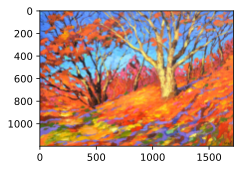

In [4]:
style_img=d2l.Image.open('/content/drive/MyDrive/d2l-zh-master/img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

定义图像的预处理函数和后处理函数。 预处理函数preprocess对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。 后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。 由于图像打印函数要求每个像素的浮点数值在0到1之间，我们对小于0和大于1的值分别取0和1。

In [5]:
rgb_mean=torch.tensor([0.485,0.456,0.406])
rgb_std=torch.tensor([0.229,0.224,0.225])

def preprocess(img,image_shape):
  transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean,std=rgb_std)                                     
  ])
  return transforms(img).unsqueeze(0)

def postprocess(img):
  img=img[0].to(rgb_std.device)
  img=torch.clamp(img.permute(1,2,0)*rgb_std+rgb_mean,0,1)
  return torchvision.transforms.ToPILImage()(img.permute(2,0,1))

我们使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征

In [6]:
pretrained_net=torchvision.models.vgg19(pretrained=True)

为了抽取图像的内容特征和样式特征，我们可以选择VGG网络中某些层的输出。 一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。 为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即内容层，来输出图像的内容特征。 我们还从VGG中选择不同层的输出来匹配局部和全局的样式，这些图层也称为样式层。 正如 7.2节 中所介绍的，VGG网络使用了5个卷积块。 实验中，我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为样式层。 这些层的索引可以通过打印pretrained_net实例获取。

In [7]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

使用VGG层抽取特征时，我们只需要用到从输入层到最靠近输出层的内容层或样式层之间的所有层。 下面构建一个新的网络net，它只保留需要用到的VGG的所有层。

In [8]:
net=nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers+style_layers)+1)])

给定输入X，如果我们简单地调用前向计算net(X)，只能获得最后一层的输出。 由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和样式层的输出。

In [9]:
def extract_features(X,content_layers,style_layers):
  contents=[]
  styles=[]
  for i in range(len(net)):
    X=net[i](X)
    if i in style_layers:
      styles.append(X)
    if i in content_layers:
      contents.append(X)
  return contents,styles

下面定义两个函数：get_contents函数对内容图像抽取内容特征； get_styles函数对样式图像抽取样式特征。 因为在训练时无须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容特征和样式特征。 由于合成图像是样式迁移所需迭代的模型参数，我们只能在训练过程中通过调用extract_features函数来抽取合成图像的内容特征和样式特征。

In [10]:
def get_contents(image_shape,device):
  content_X=preprocess(content_img,image_shape).to(device)
  contents_Y,_=extract_features(content_X,content_layers,style_layers)
  return content_X,contents_Y

def get_styles(image_shape,device):
  style_X=preprocess(style_img,image_shape).to(device)
  _,styles_Y=extract_features(style_X,content_layers,style_layers)
  return style_X,styles_Y

定义损失函数

与线性回归中的损失函数类似，内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。

In [11]:
def content_loss(Y_hat,Y):
  return torch.square(Y_hat-Y.detach()).mean()

样式损失与内容损失类似，也通过平方误差函数衡量合成图像与样式图像在样式上的差异。

In [12]:
def gram(X):
  num_channels,n=X.shape[1],X.numel()//X.shape[1]
  X=X.reshape((num_channels,n))
  return torch.matmul(X,X.T)/(num_channels*n)

自然地，样式损失的平方误差函数的两个格拉姆矩阵输入分别基于合成图像与样式图像的样式层输出。这里假设基于样式图像的格拉姆矩阵gram_Y已经预先计算好了。

In [13]:
def style_loss(Y_hat,gram_Y):
  return torch.square(gram(Y_hat)-gram_Y.detach()).mean()

有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。 一种常见的降噪方法是总变差降噪： 假设  xi,j  表示坐标  (i,j)  处的像素值，降低总变差损失

In [25]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

风格转移的损失函数是内容损失、风格损失和总变化损失的加权和

In [21]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

在样式迁移中，合成的图像是训练期间唯一需要更新的变量。因此，我们可以定义一个简单的模型 SynthesizedImage，并将合成的图像视为模型参数。模型的前向计算只需返回模型参数即可。

In [16]:
class SynthesizedImage(nn.Module):
  def __init__(self,img_shape,**kwargs):
    super(SynthesizedImage,self).__init__(**kwargs)
    self.weight=nn.Parameter(torch.rand(*img_shape))
  
  def forward(self):
    return self.weight

下面，我们定义 get_inits 函数。该函数创建了合成图像的模型实例，并将其初始化为图像 X 。样式图像在各个样式层的格拉姆矩阵 styles_Y_gram 将在训练前预先计算好。

In [20]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

在训练模型进行样式迁移时，我们不断抽取合成图像的内容特征和样式特征，然后计算损失函数。下面定义了训练循环。

In [23]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X
  

训练模型

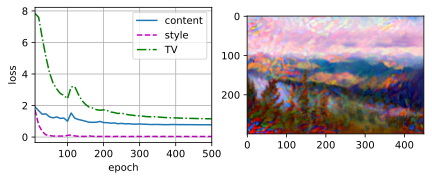

In [26]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)